### 3명의 얼굴을 학습하여 인식하기

In [1]:
from PIL import Image
import numpy as np
import glob

---
### 전체 사진중 최대 해상도 찾기

In [2]:
dirNames = ['Aiden', 'Andrew', 'Cathy']

In [3]:
# folder중 최대 해상도 찾기
widthRatio = []
heightRatio = []
for name in dirNames:
    for file in sorted(glob.glob(f"/kaggle/input/data-face/{name}/image*.jpg")):
        img = np.array(Image.open(file))
        widthRatio.append(img.shape[1])
        heightRatio.append(img.shape[0])

In [4]:
print('너비 최대 해상도 :', np.max(widthRatio))
print('높이 최대 해상도 :', np.max(heightRatio))

너비 최대 해상도 : 299
높이 최대 해상도 : 381


> 해상도의 크기 : 400 * 300 

---
### 전체 사진을 흑백으로 변경하고 검은색 배경(400*300)의 중앙에 일치시켜 저장하기 

In [5]:
# 작업 폴더 생성
import os
os.mkdir("./Face")
os.mkdir("./Face/Gray")

In [6]:
# 이름별 directory 생성
for name in dirNames:
    os.mkdir(f"./Face/Gray/{name}")

In [7]:
for name in dirNames:
    fileCount = 0
    for file in sorted(glob.glob(f"/kaggle/input/data-face/{name}/image*.jpg")):
        img = Image.open(file)
        imgResize = img.convert('L')
        imgArray = np.array(imgResize)

        imgDummy = np.zeros(400*300).reshape(400, 300)
        rowNum = (400 - imgArray.shape[0]) / 2
        colNum = (300 - imgArray.shape[1]) / 2

        k = 0
        for i in range(int(rowNum), int(rowNum)+imgArray.shape[0]):
            l = 0
            for j in range(int(colNum), int(colNum)+imgArray.shape[1]):
                imgDummy[i,j] = imgArray[k,l]
                l+=1
            k+=1
        img2 = Image.fromarray(imgDummy.astype('uint8'), 'L')
        img2.save(f"/kaggle/working/Face/Gray/{name}/image_{fileCount:04d}.jpg", "JPEG")
        fileCount+=1


### 흑백 사진들을 numpy 배열을 이용하여 train data 만들기

In [9]:
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 400

In [10]:
train_data = np.zeros(number_of_data*img_width_size*img_height_size).reshape(number_of_data, img_height_size, img_width_size)

i = 0
for name in dirNames:
    for file in sorted(glob.glob(f"/kaggle/working/Face/Gray/{name}/*.jpg")):
        img = np.array(Image.open(file))
        train_data[i,:,:] = img
        i+=1
        

In [11]:
train_data.shape

(54, 400, 300)

### 이미지 확인

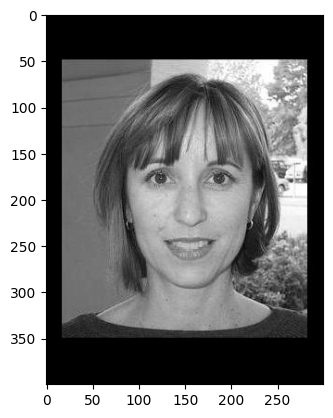

In [14]:
import matplotlib.pyplot as plt

plt.imshow(train_data[50], cmap='gray')
plt.show()

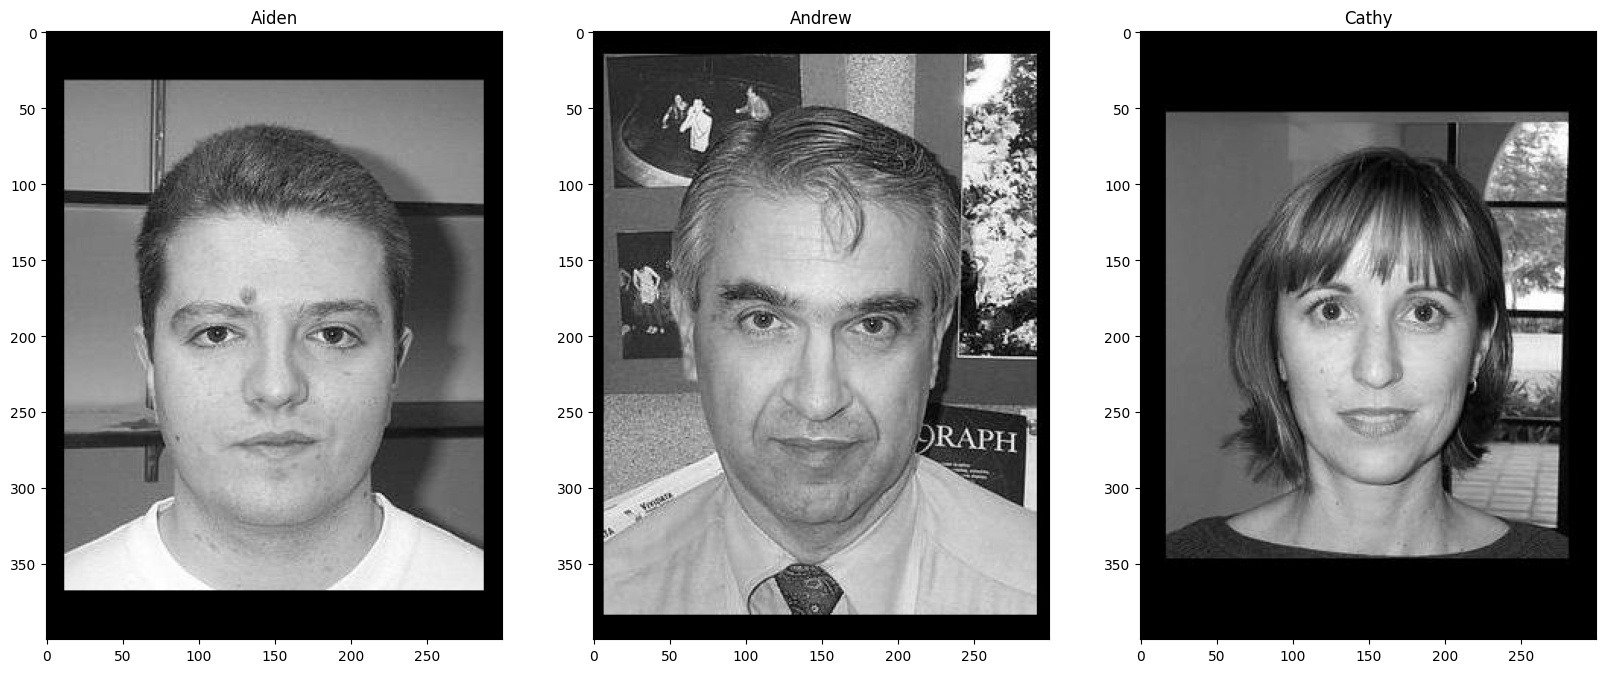

In [15]:
# 여러개 이미지를 같이 보기
plt.figure(figsize=(20, 20))
orderNo = range(0, len(dirNames)*18, 18)

for i in range(1, len(dirNames)+1):
    plt.subplot(1, len(dirNames), i)
    plt.imshow(train_data[orderNo[i-1]].reshape(400, 300), cmap='gray')
    plt.title(dirNames[i-1])

---
### Target Data만들기

In [24]:
a = [0 for _ in range(18)]
[num for num in range(3)]

[0, 1, 2]

In [30]:
a = [0 for _ in range(18)]
b = [1 for _ in range(18)]
c = [2 for _ in range(18)]

target_data = a + b + c
print(target_data)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [31]:
target_data = []
for num in range(3):
    for _ in range(18):
        target_data.append(num)

print(target_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [16]:
target_data = [num for num in range(3) for _ in range(18)]
print(target_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


---
### Data들을 Tensor로 변환

In [17]:
import torch

train_input = torch.tensor(train_data)
train_target = torch.tensor(target_data)

print(train_input.shape)
print(train_target.shape)

torch.Size([54, 400, 300])
torch.Size([54])


### train data를 훈련과 검증으로 나누면서, 정규화, 채널 추가

In [18]:
from sklearn.model_selection import train_test_split

train_input = train_input.unsqueeze(1).float() / 255.0  # 채널 차원 추가 및 정규화
train_input, val_input, train_target, val_target = \
                            train_test_split(
                                train_input,
                                train_target,
                                test_size=0.2,
                                random_state=42
                            )

In [20]:
# dimension 확인
print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)

torch.Size([43, 1, 400, 300]) torch.Size([43])
torch.Size([11, 1, 400, 300]) torch.Size([11])


---
### CNN 신경망 만들기

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [22]:
# Dataset 및 DataLoader 생성
batch_size = 32 # mini batch
train_dataset = TensorDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

---
### 모델 정의

In [40]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * int(400/4) * int(300/4), 128) 
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.9)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [49]:
# 손실함수와 옵티마이저
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [50]:
# 학습 함수 정의
def train(model, train_loader, criterion, optimizer, device):
    model.train() # 뉴런들이 훈련모드로 동작하도록 설정 
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화 
        outputs = model(inputs) # 내부적으로 model.forward(inputs) 호출하여 예측값 얻음 
        loss = criterion(outputs, targets) # 모델의 예측값과 실제 타겟 간의 손실을 계산 
        loss.backward() # 손실에 대한 그래디언트를 계산하고 역전파 
        optimizer.step() # 계산된 그래디언트를 사용하고 모델의 파라미터를 업데이트 
    return loss.item() # 현재 배치의 손실값을 반환 

In [51]:
# 평가함수 
def evaluate(model, val_loader, criterion, device):
    model.eval() # 평가모드로 동작하도록 설정 
    total_loss = 0 # 전체 손실 합계 
    correct = 0 # 정확하게 예측한 샘플 수 
    total = 0 # 전체 샘플 수
    with torch.no_grad() : # 평가 중에는 그래디언트 계산이 필요 없으므로 메모리 사용량 및 연산 속도 향상
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) # 예측값 발생 
            loss = criterion(outputs, targets) # 손실계산
            total_loss += loss.item() # 전체 손실에 더하기 
            _, predicted = outputs.max(1) # 전체 샘플에 대해 가장 높은 확률을 가진 인덱스 
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # 예측값과 실제값이 일치하는 경우 True를 발생 
        return total_loss/len(val_loader), correct/total # 평균손실과 정확도 

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480000, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.9, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [53]:
# 훈련 반복후 차트로 확인
train_loss_scores = [] 
val_loss_scores = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    train_loss_scores.append(train_loss)
    val_loss_scores.append(val_loss)
    print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss :{train_loss:.4f}, Val Loss : {val_loss:.4f}, Val Accuracy : {val_accuracy:.4f}")

Epoch[1/100], Train Loss :21.6187, Val Loss : 3.6145, Val Accuracy : 0.1818
Epoch[2/100], Train Loss :13.6192, Val Loss : 1.6748, Val Accuracy : 0.4545
Epoch[3/100], Train Loss :4.2407, Val Loss : 1.4096, Val Accuracy : 0.4545
Epoch[4/100], Train Loss :4.6444, Val Loss : 0.8650, Val Accuracy : 0.6364
Epoch[5/100], Train Loss :1.3390, Val Loss : 1.2560, Val Accuracy : 0.1818
Epoch[6/100], Train Loss :1.7294, Val Loss : 1.4578, Val Accuracy : 0.1818
Epoch[7/100], Train Loss :1.7028, Val Loss : 0.9541, Val Accuracy : 0.5455
Epoch[8/100], Train Loss :1.5273, Val Loss : 0.9115, Val Accuracy : 0.7273
Epoch[9/100], Train Loss :0.7855, Val Loss : 1.0751, Val Accuracy : 0.1818
Epoch[10/100], Train Loss :0.7674, Val Loss : 1.0041, Val Accuracy : 0.5455
Epoch[11/100], Train Loss :0.8242, Val Loss : 0.9013, Val Accuracy : 0.8182
Epoch[12/100], Train Loss :0.9384, Val Loss : 0.7528, Val Accuracy : 0.8182
Epoch[13/100], Train Loss :0.7031, Val Loss : 0.7061, Val Accuracy : 0.8182
Epoch[14/100], Trai

In [54]:
# 훈련 평가
train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
print(f"Loss : {train_loss:.4f}, Accuracy : {train_accuracy:.4f}")

Loss : 0.0002, Accuracy : 1.0000


In [55]:
# 검증 평가
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
print(f"Loss : {val_loss:.4f}, Accuracy : {val_accuracy:.4f}")

Loss : 0.5971, Accuracy : 0.9091


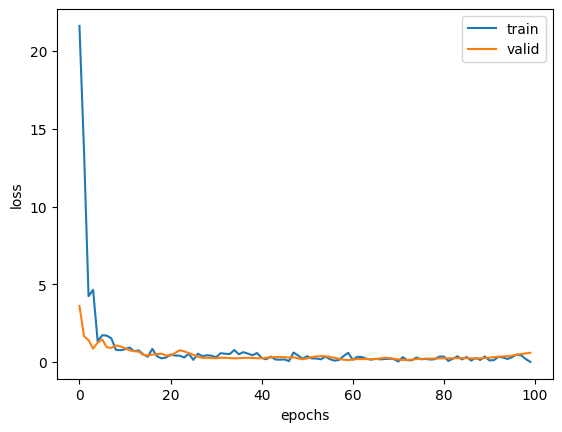

In [56]:
# 시각화 해보기
plt.plot(train_loss_scores)
plt.plot(val_loss_scores)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'valid'])
# plt.ylim(0, 10)
plt.show()

---
#### 이미지 불러와서 예측해 보기


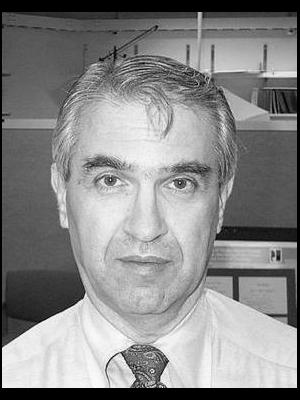

In [57]:
# Image
img = Image.open("/kaggle/working/Face/Gray/Andrew/image_0002.jpg")
img

In [58]:
# Image를 numpy배열로 변환
img = np.array(img)
img.shape

(400, 300)

In [59]:
# numpy배열을 torch로 변환
img = torch.from_numpy(img)
img.shape

torch.Size([400, 300])

In [60]:
# 정규화 및 채널 차원 추가
img = img.unsqueeze(0).float() / 255.0
img.shape

torch.Size([1, 400, 300])

In [61]:
# class들의 이름 정의
classes = ['Aiden','Andrew','Cathy']
classes

['Aiden', 'Andrew', 'Cathy']

In [62]:
# 예측 함수 
def predict_single_image(model, image, device, classes):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1) # 가장 높은 확률의 클래스 인덱스 선택 
        predicted_class = classes[predicted.item()]
    return predicted_class

In [63]:
# 예측 수행
predict_single_image(model, img, device, classes)

'Andrew'

---
### 학습한 모델 저장하기

In [64]:
# 전체 모델 저장
torch.save(model, './cnn_3_persons.pth')

---
### AI 서비스

In [66]:
# 전체 모델 불러오기
model1 = torch.load("./cnn_3_persons.pth", weights_only=False)
model1.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480000, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.9, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [67]:
predict_single_image(model1, img, device, classes)

'Andrew'